In [2]:
import numpy as np

import matplotlib.pyplot as plt

In [11]:
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 10

In [41]:
def get_earth_reflect_spectrum():
    """
    Get the geometric albedo spectrum of the Earth around the Sun.
    This was produced by Tyler Robinson using the VPL Earth Model
    (Robinson et al., 2011)
    Returns
    -------
    lamhr : numpy.ndarray
    Ahr : numpy.ndarray
    fstar : numpy.ndarray
    """

    fn = 'earth_quadrature_radiance_refl.dat.txt'
    model = np.loadtxt(fn, skiprows=8)
    lamhr = model[:,0]
    radhr = model[:,1]
    fstar = model[:,2]
    reflhr = model[:,3]
    Ahr   = np.pi*(np.pi*radhr/fstar) # hi-resolution reflectivity
    return lamhr, Ahr, fstar

In [42]:
lam, albedo, _ = get_earth_reflect_spectrum()

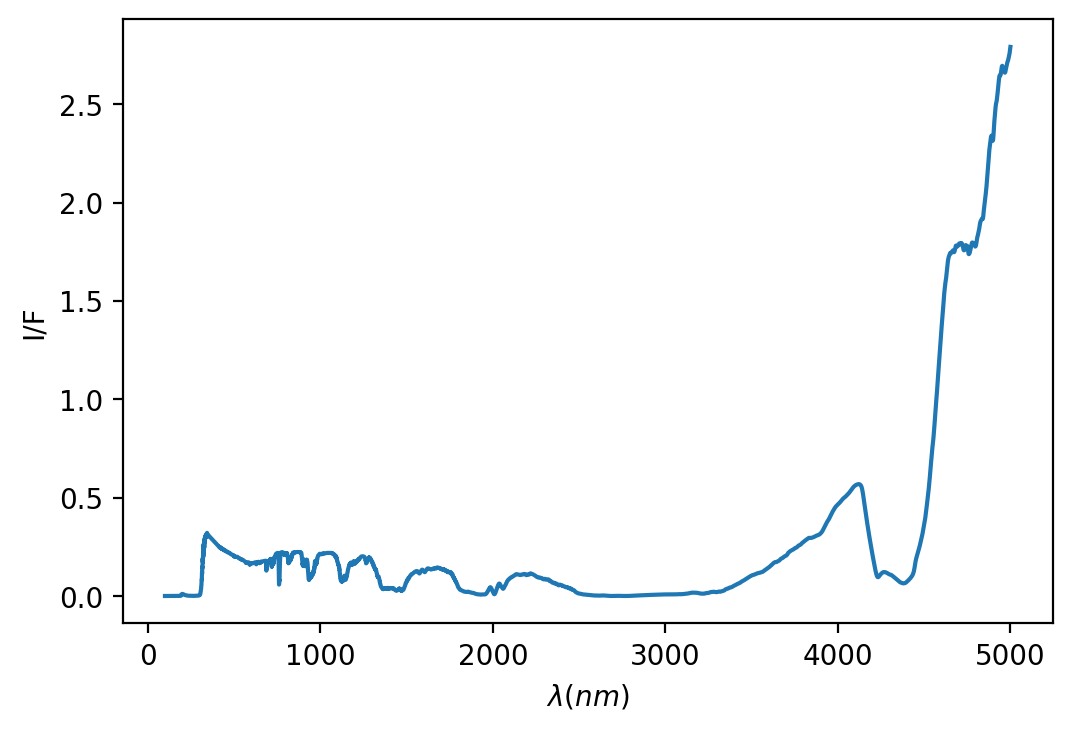

In [44]:
# file = "psg_earth_albedo_300-1000nm_R500.txt"
# lam, albedo = np.genfromtxt(file, usecols=[0,1]).T

lam *= 1000
plt.figure()
plt.ylabel('I/F')
plt.xlabel('$\lambda (nm)$')
plt.plot(lam, albedo)
plt.show()

In [45]:
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

In [46]:
lam_0 = 550
R = 40
dlam = lam_0 / R
sigma = dlam / 2.355

albedo_smooth = gaussian_filter1d(albedo, sigma, mode='nearest')

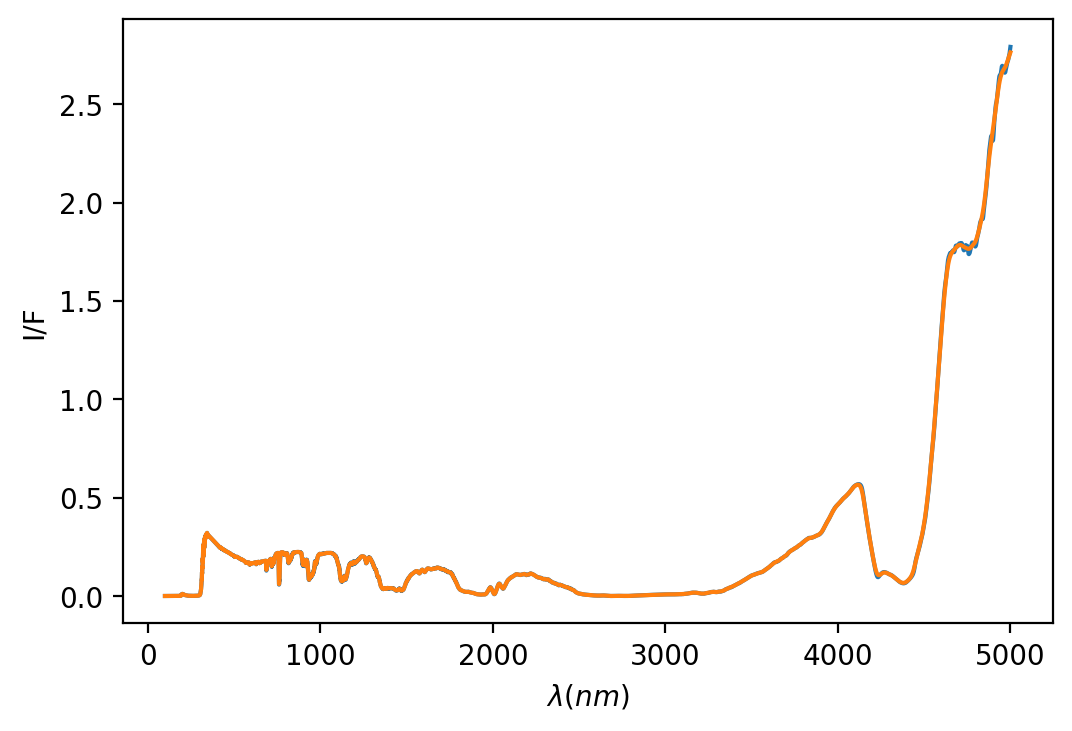

In [47]:
# lam *= 1000
plt.figure()
plt.ylabel('I/F')
plt.xlabel('$\lambda (nm)$')
plt.plot(lam, albedo)
plt.plot(lam, albedo_smooth)
plt.show()

In [48]:
albedo_f = interp1d(lam, albedo, bounds_error=False, fill_value=(albedo.min(), albedo.max()))

In [49]:
nlam=10
albedo_box_smooth = np.zeros_like(lam)
for i, wlen in enumerate(lam):
    dlam = wlen / R
    lammin = wlen - dlam/2
    lammax = wlen + dlam/2
    lams = np.linspace(lammin, lammax, nlam)
#     print(lams)
#     print(albedo_f(lams))
    albedo_box_smooth[i] = np.mean(albedo_f(lams))


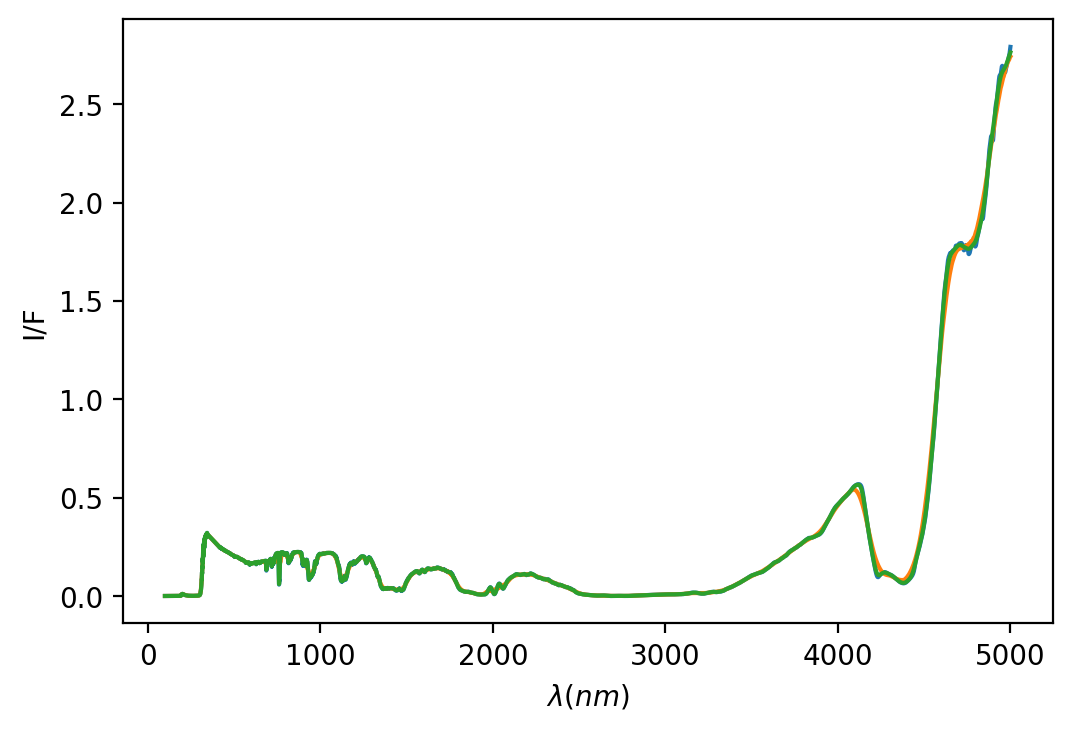

In [50]:
plt.figure()
plt.ylabel('I/F')
plt.xlabel('$\lambda (nm)$')
plt.plot(lam, albedo)
plt.plot(lam, albedo_box_smooth)
plt.plot(lam, albedo_smooth)
plt.show()

# Section of spectrum we want to optimize wavelength grid 

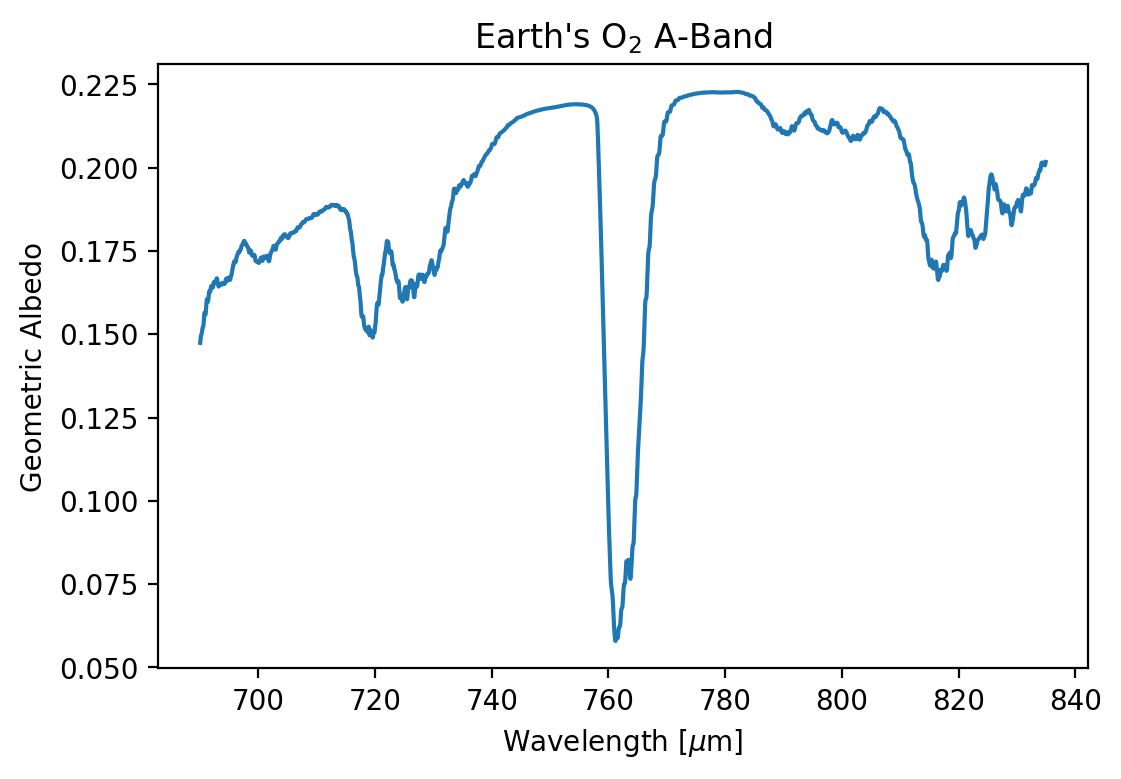

In [111]:
lammin = 684.0 - 10.0
lammax = 836.0 + 10.0


lammin = 0.750 * 1000 -60
lammax = 0.775 * 1000 + 60

# Create a wavelength mask
m = (lam > lammin) & (lam < lammax)

# Plot the band
plt.plot(lam[m], albedo[m])
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band")
plt.show()

In [112]:
def construct_lam(lammin, lammax, Res=None, dlam=None):
    # Keyword catching logic
    goR = False
    goL = False
    if ((Res is None) and (dlam is None)) or (Res is not None) and (dlam is not None):
        print("Error in construct_lam: Must specify either Res or dlam, but not both")
    elif Res is not None:
        goR = True
    elif dlam is not None:
        goL = True
    else:
        print("Error in construct_lam: Should not enter this else statment! :)")
        return None, None

    # If Res is provided, generate equal resolving power wavelength grid
    if goR:

        # Set wavelength grid
        dlam0 = lammin/Res
        dlam1 = lammax/Res
        lam  = lammin #in [um]
        Nlam = 1
        while (lam < lammax + dlam1):
            lam  = lam + lam/Res
            Nlam +=1
        lam    = np.zeros(Nlam)
        lam[0] = lammin
        for j in range(1,Nlam):
            lam[j] = lam[j-1] + lam[j-1]/Res
        Nlam = len(lam)
        dlam = np.zeros(Nlam) #grid widths (um)
#         print(lam)
        # Set wavelength widths
        for j in range(1,Nlam-1):
            dlam[j] = 0.5*(lam[j+1]+lam[j]) - 0.5*(lam[j-1]+lam[j])

        #Set edges to be same as neighbor
        dlam[0] = dlam0#dlam[1]
        dlam[Nlam-1] = dlam1#dlam[Nlam-2]

        lam = lam[:-1]
        dlam = dlam[:-1]

    # If dlam is provided, generate evenly spaced grid
    if goL:
        lam = np.arange(lammin, lammax+dlam, dlam)
        dlam = dlam + np.zeros_like(lam)

    return lam, dlam

In [113]:
from scipy.stats import binned_statistic
def downbin_spec(specHR, lamHR, lamLR, dlam=None):
    """
    Re-bin spectum to lower resolution using :py:obj:`scipy.binned_statistic`
    with ``statistic = 'mean'``. This is a "top-hat" convolution.
    Parameters
    ----------
    specHR : array-like
        Spectrum to be degraded
    lamHR : array-like
        High-res wavelength grid
    lamLR : array-like
        Low-res wavelength grid
    dlam : array-like, optional
        Low-res wavelength width grid
    Returns
    -------
    specLR : :py:obj:`numpy.ndarray`
        Low-res spectrum
    """

    if dlam is None:
        ValueError("Please supply dlam in downbin_spec()")

    # Reverse ordering if wl vector is decreasing with index
    if len(lamLR) > 1:
        if lamHR[0] > lamHR[1]:
            lamHI = np.array(lamHR[::-1])
            spec = np.array(specHR[::-1])
        if lamLR[0] > lamLR[1]:
            lamLO = np.array(lamLR[::-1])
            dlamLO = np.array(dlam[::-1])

    # Calculate bin edges
    LRedges = np.hstack([lamLR - 0.5*dlam, lamLR[-1]+0.5*dlam[-1]])

    # Call scipy.stats.binned_statistic()
    specLR = binned_statistic(lamHR, specHR, statistic="mean", bins=LRedges)[0]

    return specLR

In [114]:
# define set of resolving powers
# R = np.array([1, 10, 30, 70, 100, 150, 200, 500])
R = np.array([1, 10, 30, 70, 100, 150, 200, 500, 1000])
# R = np.arange(70, 190, 20)

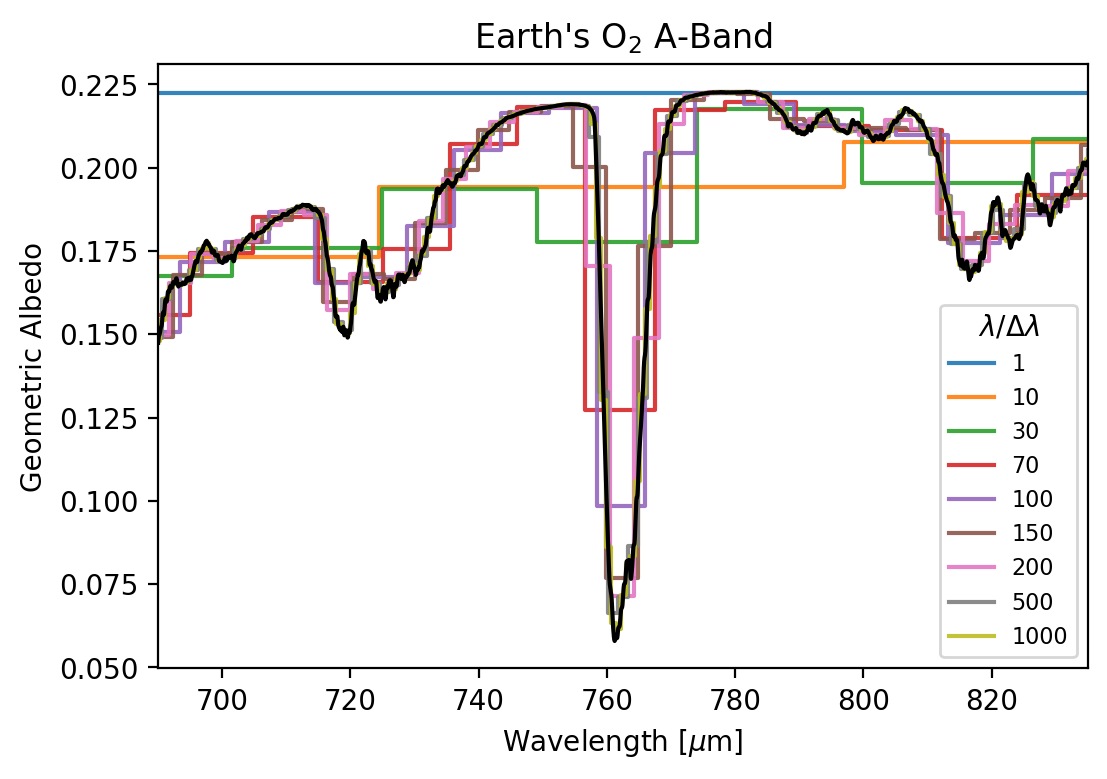

In [115]:
ifs = False
bottom_val = np.zeros(len(R))

# Loop over R
for i, r in enumerate(R):

    
    if ifs:
        wl, dwl = construct_lam_ifs(lammin, lammax, r, verbose=False)
#         print(wl.size, dwl.size)
        Alr = downbin_spec_ifs(lam, dwl, albedo)
    else:                               
        # Construct new low-res wavelength grid
        wl, dwl = construct_lam(lammin, lammax, r)
        #     print(wl)
        # Down-bin flux to low-res
        Alr = downbin_spec(albedo,lam, wl, dlam=dwl)

    # Plot
#     plt.step(wl, Alr, where="mid", alpha = 0.5, color=f"C{i}", label = "%i" %r)
    plt.plot(wl, Alr, drawstyle='steps-mid', alpha = 0.9, color=f"C{i}", label = "%i" %r)
#     plt.scatter(wl, Alr, color=f"C{i}")

    # Save bottom value
    bottom_val[i] = np.min(Alr)

# Finsh plot
plt.plot(lam[m], albedo[m], c = "k")
plt.xlim(lammin, lammax)

# plt.xlim(lammin, lammax)
plt.legend(fontsize = 8, title = r"$\lambda / \Delta \lambda$")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band");

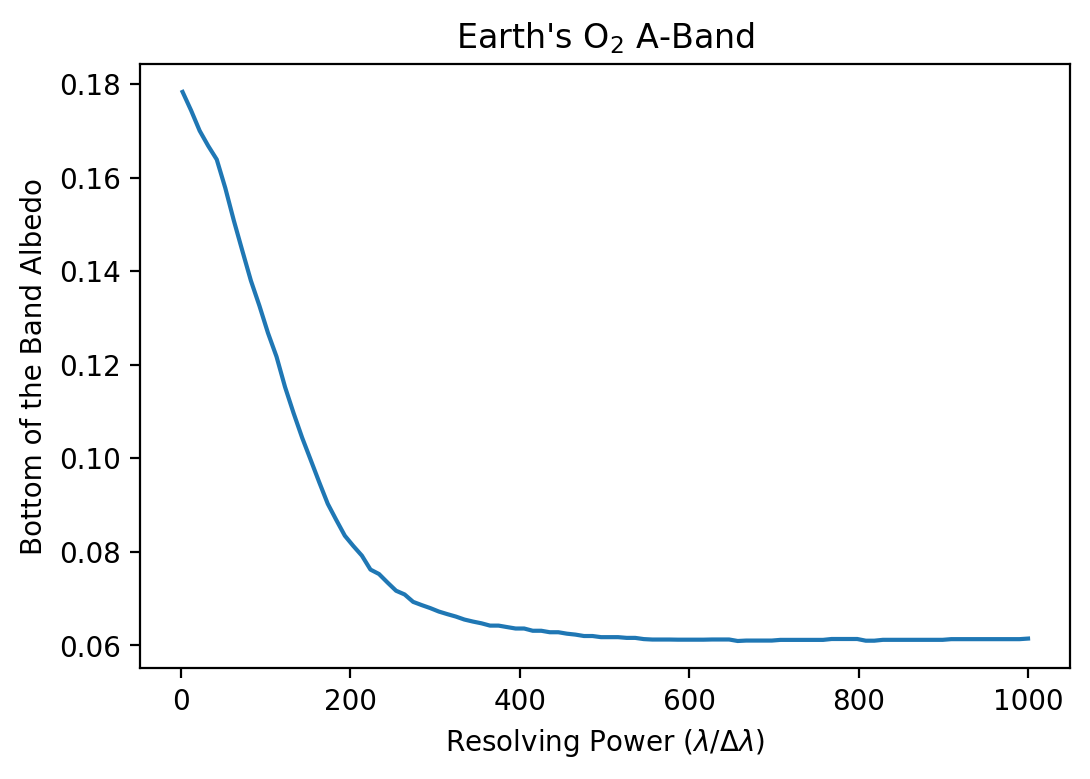

In [116]:
# Create resolution array to loop over
Nres = 100
R = np.linspace(2,1000,Nres)

# R = np.arange(70, 190, 20)
# Nres = len(R)
# Array to store bottom-of-band albedos
bottom_val = np.zeros(len(R))

# Loop over R
for i, r in enumerate(R):

    # Construct new low-res wavelength grid
    if ifs:
        wl, dwl = construct_lam_ifs(lammin, lammax, r, verbose=False)
#         print(wl.size, dwl.size)
        Alr = downbin_spec_ifs(lam, dwl, albedo)
    else:                               
        # Construct new low-res wavelength grid
        wl, dwl = construct_lam(lammin, lammax, r)
        #     print(wl)
        # Down-bin flux to low-res
        Alr = downbin_spec(albedo,lam, wl, dlam=dwl)

    # Save bottom value
    bottom_val[i] = np.min(Alr)


# Make plot
plt.plot(R, bottom_val);
plt.xlabel(r"Resolving Power ($\lambda / \Delta \lambda$)")
plt.ylabel("Bottom of the Band Albedo")
plt.title(r"Earth's O$_2$ A-Band")
plt.show()

<ipython-input-119-9ca71b73a03e>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Alrs = np.array(Alrs).reshape((Ntest, Nres), order='F')
<ipython-input-119-9ca71b73a03e>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lams = np.array(lams).reshape((Ntest, Nres), order='F')


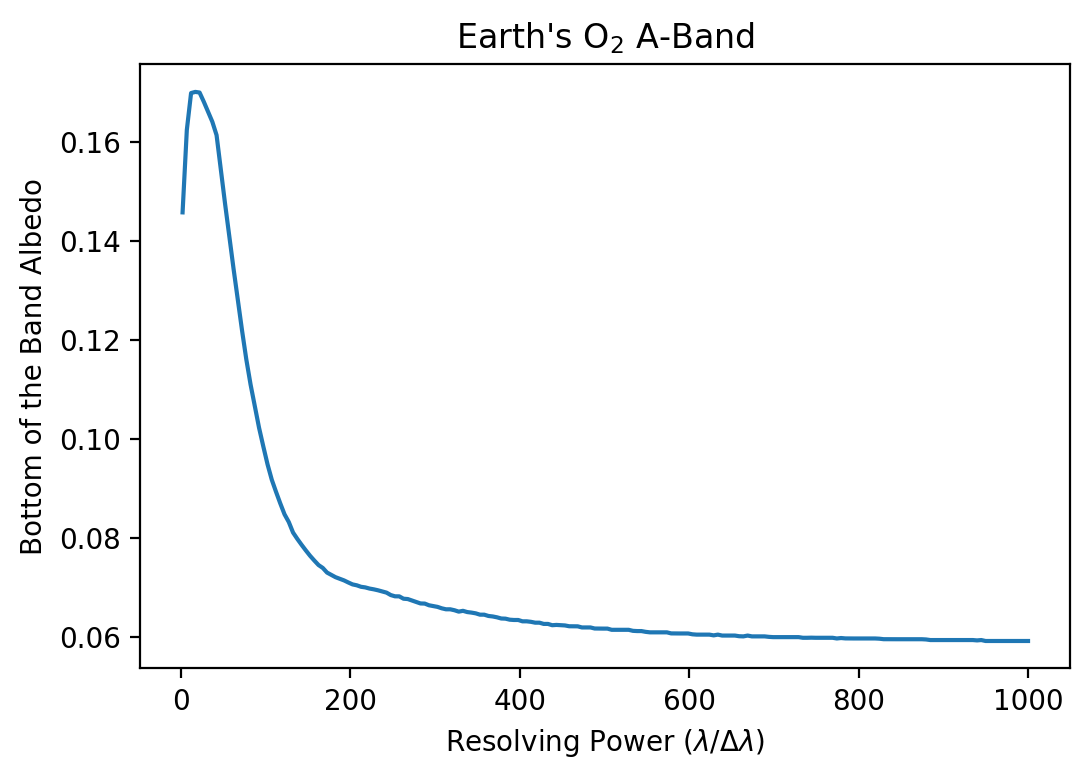

In [119]:
# Create resolution array to loop over
Nres = 200
R = np.linspace(2,1000, Nres)

# R = np.arange(70, 190, 20)
Nres = len(R)
# Set number of initial positions
Ntest = 40

# Arrays to save quantities
bottom_vals = np.nan*np.zeros([len(R), Ntest])
best = np.nan*np.zeros(len(R), dtype=int)
Alrs = []
lams = []

# Loop over R
for i, r in enumerate(R):

    # Set grid of minimum wavelengths to iterate over
    lammin_vals = np.linspace(lammin - lammin/r, lammin+lammin/r, Ntest)
#     lammin_vals = np.linspace(lammin - 1.0*0.762*1000/r, lammin, Ntest)
    # Loop over minimum wavelengths to adjust bin centers
    for j, lmin in enumerate(lammin_vals):

        if ifs:
            wl, dwl = construct_lam_ifs(lmin, lammax, r, verbose=False)
#             print(wl.size, dwl.size)
            Alr = downbin_spec_ifs(lam, dwl, albedo)
        else:                               
            # Construct new low-res wavelength grid
            wl, dwl = construct_lam(lmin, lammax, r)
            #     print(wl)
            # Down-bin flux to low-res
            Alr = downbin_spec(albedo,lam, wl, dlam=dwl)

        # Keep track of the minimum
        is_best = ~np.isfinite(best[i]) or (np.nansum(np.min(Alr) < bottom_vals[i,:]) > 0)
 
        if is_best:
            best[i] = j

        # Save quantities
        bottom_vals[i,j] = np.min(Alr)
        Alrs.append(Alr)
        lams.append(wl)
#     print(wl)
# Reshape saved arrays
Alrs = np.array(Alrs).reshape((Ntest, Nres), order='F')
lams = np.array(lams).reshape((Ntest, Nres), order='F')
best =  np.array(best, dtype=int)

# Plot the global minimum
plt.plot(R, np.min(bottom_vals, axis = 1));
plt.xlabel(r"Resolving Power ($\lambda / \Delta \lambda$)")
plt.ylabel("Bottom of the Band Albedo")
# plt.xlim([100, 500])
plt.title(r"Earth's O$_2$ A-Band");

[ 0  1  2  4  7 12 21 35 59 99]
1035.0 1035.0
788.3595988538682 900.7403726159883
747.3558897243108 876.7670151061609
716.4659190467846 855.4796566459764
708.5956121343445 853.5796143546074
701.096654275093 835.5928923630335
696.4295748267466 838.3772904065094
693.88671875 835.202058538198
692.3162955465586 835.2384881801795
691.3841733870968 836.3768906653575
10


(690.0, 835.0)

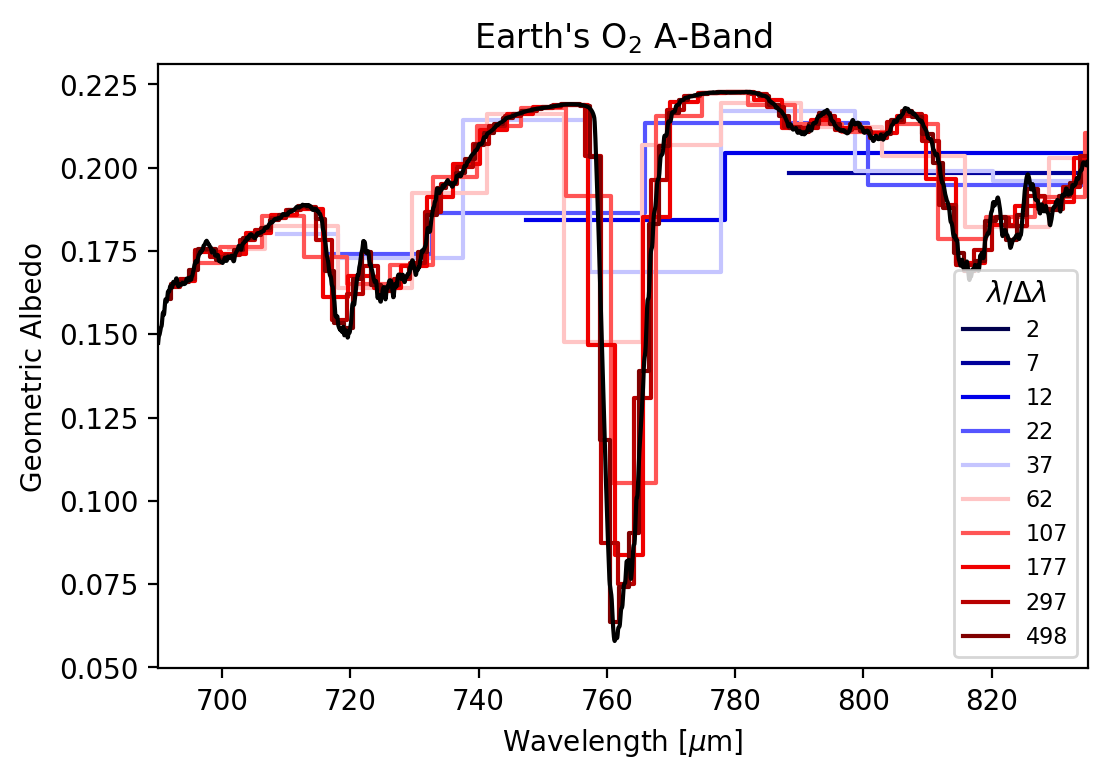

In [120]:

# Get some log-spaced indices so we're not plotting all R
iz = np.array(np.logspace(np.log10(1), np.log10(100), 10).round(), dtype=int) - 1 
# iz = np.array(np.logspace(np.log10(1), np.log10(10), 10).round(), dtype=int) - 1

print(iz)
colors = plt.cm.seismic(np.linspace(0,1, 10))
# Loop over R
count = 0
for i, r in enumerate(R):

    
    # Plot some of the resolutions
    if i in iz:
        
        wlens = lams[best[i], i]
        alb = Alrs[best[i], i]
        
        plt.plot(wlens, alb,  drawstyle='steps-mid', alpha = 0.5*2, color=colors[count], label=f'{int(r)}')
        print(wlens.min(), wlens.max())
        count +=1
#         plt.scatter(wl, Alr, color=f"C{i}")
#         plt.plot(lams[best[i], i], Alrs[best[i], i], ls = "steps-mid", alpha = 0.5, label = "%i" %r)
print(count)

# Finsh plot
plt.plot(lam[m], albedo[m], c = "k")
plt.legend(fontsize = 8, title = r"$\lambda / \Delta \lambda$")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
# plt.xlim(0.9*lammin, 1.1*lammax)
# plt.axvline(719)
plt.title(r"Earth's O$_2$ A-Band");
plt.xlim(lammin, lammax)
# plt.axvline(684)
# plt.axvline(836)

In [121]:
a = np.arange(1,11)

In [122]:
a

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [123]:
10-1

9

In [125]:
1 - a/9

array([ 0.88888889,  0.77777778,  0.66666667,  0.55555556,  0.44444444,
        0.33333333,  0.22222222,  0.11111111,  0.        , -0.11111111])

In [126]:
def searchuniform(xp, dx): 
    i, _ = np.divmod(xp, dx) 
    return i.astype('int64')

In [143]:
x, dx = np.linspace(0, 1, 10000000, retstep=True) 
x_r = np.random.rand(10000) 

In [128]:
%timeit np.searchsorted(x, x_r) 

6.88 ms ± 68.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [129]:
%timeit searchuniform(x_r, dx)

345 µs ± 457 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [130]:
np.searchsorted(x, x_r) 

array([1912309, 7903173, 1091733, ...,  356745, 4980057, 4984822],
      dtype=int64)

In [131]:
searchuniform(x_r, dx)

array([1912308, 7903172, 1091732, ...,  356744, 4980056, 4984821],
      dtype=int64)

In [148]:
def find_nearest(arr, val):
    return arr[np.abs(arr-val).argmin(axis=0)]

In [151]:
find_nearest(x, x_r[0])

0.17665961766596178

In [132]:
class RegularGridInterpolator:
    """
    Interpolation on a regular grid in arbitrary dimensions
    The data must be defined on a regular grid; the grid spacing however may be
    uneven. Linear and nearest-neighbor interpolation are supported. After
    setting up the interpolator object, the interpolation method (*linear* or
    *nearest*) may be chosen at each evaluation.
    Parameters
    ----------
    points : tuple of ndarray of float, with shapes (m1, ), ..., (mn, )
        The points defining the regular grid in n dimensions.
    values : array_like, shape (m1, ..., mn, ...)
        The data on the regular grid in n dimensions.
    method : str, optional
        The method of interpolation to perform. Supported are "linear" and
        "nearest". This parameter will become the default for the object's
        ``__call__`` method. Default is "linear".
    bounds_error : bool, optional
        If True, when interpolated values are requested outside of the
        domain of the input data, a ValueError is raised.
        If False, then `fill_value` is used.
    fill_value : number, optional
        If provided, the value to use for points outside of the
        interpolation domain. If None, values outside
        the domain are extrapolated.
    Methods
    -------
    __call__
    Notes
    -----
    Contrary to LinearNDInterpolator and NearestNDInterpolator, this class
    avoids expensive triangulation of the input data by taking advantage of the
    regular grid structure.
    If any of `points` have a dimension of size 1, linear interpolation will
    return an array of `nan` values. Nearest-neighbor interpolation will work
    as usual in this case.
    .. versionadded:: 0.14
    Examples
    --------
    Evaluate a simple example function on the points of a 3-D grid:
    >>> from scipy.interpolate import RegularGridInterpolator
    >>> def f(x, y, z):
    ...     return 2 * x**3 + 3 * y**2 - z
    >>> x = np.linspace(1, 4, 11)
    >>> y = np.linspace(4, 7, 22)
    >>> z = np.linspace(7, 9, 33)
    >>> xg, yg ,zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)
    >>> data = f(xg, yg, zg)
    ``data`` is now a 3-D array with ``data[i,j,k] = f(x[i], y[j], z[k])``.
    Next, define an interpolating function from this data:
    >>> my_interpolating_function = RegularGridInterpolator((x, y, z), data)
    Evaluate the interpolating function at the two points
    ``(x,y,z) = (2.1, 6.2, 8.3)`` and ``(3.3, 5.2, 7.1)``:
    >>> pts = np.array([[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]])
    >>> my_interpolating_function(pts)
    array([ 125.80469388,  146.30069388])
    which is indeed a close approximation to
    ``[f(2.1, 6.2, 8.3), f(3.3, 5.2, 7.1)]``.
    See also
    --------
    NearestNDInterpolator : Nearest neighbor interpolation on unstructured
                            data in N dimensions
    LinearNDInterpolator : Piecewise linear interpolant on unstructured data
                           in N dimensions
    References
    ----------
    .. [1] Python package *regulargrid* by Johannes Buchner, see
           https://pypi.python.org/pypi/regulargrid/
    .. [2] Wikipedia, "Trilinear interpolation",
           https://en.wikipedia.org/wiki/Trilinear_interpolation
    .. [3] Weiser, Alan, and Sergio E. Zarantonello. "A note on piecewise linear
           and multilinear table interpolation in many dimensions." MATH.
           COMPUT. 50.181 (1988): 189-196.
           https://www.ams.org/journals/mcom/1988-50-181/S0025-5718-1988-0917826-0/S0025-5718-1988-0917826-0.pdf
    """
    # this class is based on code originally programmed by Johannes Buchner,
    # see https://github.com/JohannesBuchner/regulargrid

    def __init__(self, points, values, method="linear", bounds_error=True,
                 fill_value=np.nan):
        if method not in ["linear", "nearest"]:
            raise ValueError("Method '%s' is not defined" % method)
        self.method = method
        self.bounds_error = bounds_error

        if not hasattr(values, 'ndim'):
            # allow reasonable duck-typed values
            values = np.asarray(values)

        if len(points) > values.ndim:
            raise ValueError("There are %d point arrays, but values has %d "
                             "dimensions" % (len(points), values.ndim))

        if hasattr(values, 'dtype') and hasattr(values, 'astype'):
            if not np.issubdtype(values.dtype, np.inexact):
                values = values.astype(float)

        self.fill_value = fill_value
        if fill_value is not None:
            fill_value_dtype = np.asarray(fill_value).dtype
            if (hasattr(values, 'dtype') and not
                    np.can_cast(fill_value_dtype, values.dtype,
                                casting='same_kind')):
                raise ValueError("fill_value must be either 'None' or "
                                 "of a type compatible with values")

        for i, p in enumerate(points):
            if not np.all(np.diff(p) > 0.):
                raise ValueError("The points in dimension %d must be strictly "
                                 "ascending" % i)
            if not np.asarray(p).ndim == 1:
                raise ValueError("The points in dimension %d must be "
                                 "1-dimensional" % i)
            if not values.shape[i] == len(p):
                raise ValueError("There are %d points and %d values in "
                                 "dimension %d" % (len(p), values.shape[i], i))
        self.grid = tuple([np.asarray(p) for p in points])
        self.values = values

    def __call__(self, xi, method=None):
        """
        Interpolation at coordinates
        Parameters
        ----------
        xi : ndarray of shape (..., ndim)
            The coordinates to sample the gridded data at
        method : str
            The method of interpolation to perform. Supported are "linear" and
            "nearest".
        """
        method = self.method if method is None else method
        if method not in ["linear", "nearest"]:
            raise ValueError("Method '%s' is not defined" % method)

        ndim = len(self.grid)
        xi = _ndim_coords_from_arrays(xi, ndim=ndim)
        if xi.shape[-1] != len(self.grid):
            raise ValueError("The requested sample points xi have dimension "
                             "%d, but this RegularGridInterpolator has "
                             "dimension %d" % (xi.shape[1], ndim))

        xi_shape = xi.shape
        xi = xi.reshape(-1, xi_shape[-1])

        if self.bounds_error:
            for i, p in enumerate(xi.T):
                if not np.logical_and(np.all(self.grid[i][0] <= p),
                                      np.all(p <= self.grid[i][-1])):
                    raise ValueError("One of the requested xi is out of bounds "
                                     "in dimension %d" % i)

        indices, norm_distances, out_of_bounds = self._find_indices(xi.T)
        if method == "linear":
            result = self._evaluate_linear(indices,
                                           norm_distances,
                                           out_of_bounds)
        elif method == "nearest":
            result = self._evaluate_nearest(indices,
                                            norm_distances,
                                            out_of_bounds)
        if not self.bounds_error and self.fill_value is not None:
            result[out_of_bounds] = self.fill_value

        return result.reshape(xi_shape[:-1] + self.values.shape[ndim:])

    def _evaluate_linear(self, indices, norm_distances, out_of_bounds):
        # slice for broadcasting over trailing dimensions in self.values
        vslice = (slice(None),) + (None,)*(self.values.ndim - len(indices))

        # find relevant values
        # each i and i+1 represents a edge
        edges = itertools.product(*[[i, i + 1] for i in indices])
        values = 0.
        for edge_indices in edges:
            weight = 1.
            for ei, i, yi in zip(edge_indices, indices, norm_distances):
                weight *= np.where(ei == i, 1 - yi, yi)
            values += np.asarray(self.values[edge_indices]) * weight[vslice]
        return values

    def _evaluate_nearest(self, indices, norm_distances, out_of_bounds):
        idx_res = [np.where(yi <= .5, i, i + 1)
                   for i, yi in zip(indices, norm_distances)]
        return self.values[tuple(idx_res)]

    def _find_indices(self, xi):
        # find relevant edges between which xi are situated
        indices = []
        # compute distance to lower edge in unity units
        norm_distances = []
        # check for out of bounds xi
        out_of_bounds = np.zeros((xi.shape[1]), dtype=bool)
        # iterate through dimensions
        for x, grid in zip(xi, self.grid):
            i = np.searchsorted(grid, x) - 1
            i[i < 0] = 0
            i[i > grid.size - 2] = grid.size - 2
            indices.append(i)
            norm_distances.append((x - grid[i]) /
                                  (grid[i + 1] - grid[i]))
            if not self.bounds_error:
                out_of_bounds += x < grid[0]
                out_of_bounds += x > grid[-1]
        return indices, norm_distances, out_of_bounds

In [159]:
def f(x, y, z):
    return 2 * x**3 + 3 * y**2 - z
x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
z = np.linspace(7, 9, 33)
xg, yg ,zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)
data = f(xg, yg, zg)

In [162]:
from scipy.interpolate import RegularGridInterpolator

In [163]:
my_interpolating_function = RegularGridInterpolator((x, y, z), data)

In [164]:
pts = np.array([[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]])
my_interpolating_function(pts)

array([125.80469388, 146.30069388])

In [166]:
%timeit my_interpolating_function(pts)

172 µs ± 855 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [155]:
%load_ext line_profiler

In [165]:
%lprun -s -f my_interpolating_function -T lp_results.txt my_interpolating_function(pts)


*** Profile printout saved to text file 'lp_results.txt'. 


C:\Users\tbain\anaconda3\lib\site-packages\line_profiler\ipython_extension.py:71: UserWarning: Could not extract a code object for the object <scipy.interpolate.interpolate.RegularGridInterpolator object at 0x0000024ED7AD0D30>
  profile = LineProfiler(*funcs)


Timer unit: 1e-07 s